# Photosynthesis, single plant tutorial

This tutorial is for analyzing photosynthetic efficiency for a single plant. 

In [1]:
%matplotlib widget
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

In [3]:
# Input/output options
args = WorkflowInputs(
    images=[""],
    names="",
    result="",
    outdir=".",
    writeimg=True,
    debug="plot"
    )

In [4]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 100
pcv.params.text_size = 20
pcv.params.text_thickness = 20

In [2]:
# Input/output options
args = WorkflowInputs(
    images=[""],
    names="",
    result="",
    outdir=".",
    writeimg=True,
    debug="plot"
    )

## Input data

PSII images (3 in a set; F0, Fmin, and Fmax) are captured directly following a saturating fluorescence pulse (red light; 630 nm). These three PSII images can be used to calculate Fv/Fm (efficiency of photosystem II) for each pixel of the plant. 

To run a PSII workflow over a single PSII image set (3 images) there are 4 required inputs:

Image 1: F0 (a.k.a Fdark/null) image.
Image 2: Fmin image.
Image 3: Fmax image.
Output directory: If debug mode is set to 'print' output images from each step are produced.

In [7]:
infile = "imgs/PSII_HDR_032321_TEST_1.INF"

ps is an instance of the PSII_data class in PlantCV. The class stores each available dataset as attributes. The class stores two dataset attributes (datapath and filename) and stores each of the datasets with the following variable names: darkadapted, lightadapted, chlorophyll, spectral. The darkadapted, lightadapted, and chlorophyll datasets are stored as xarray DataArrays. The spectral dataset is stored as a PlantCV Spectral_data class instance.

The spectral dataset can contain blue (460nm), green (500nm), red (670nm), green2 (550nm), far-red (700nm), and near-infrared (800nm) frames.



Compiling: PSD
Compiling: PSL
Compiling: CHL
Compiling: CLR
Compiling: SPC


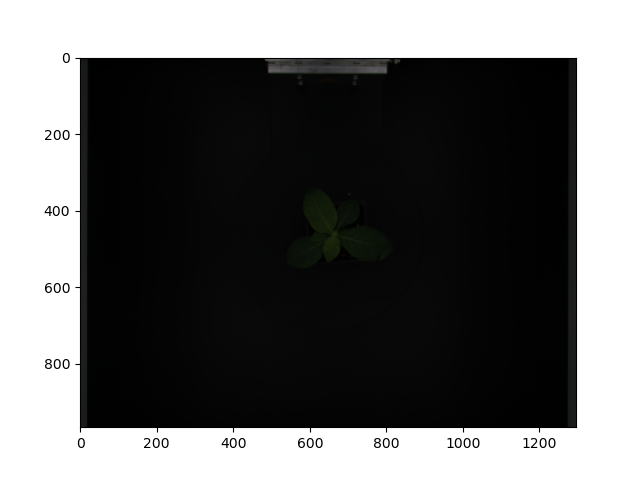

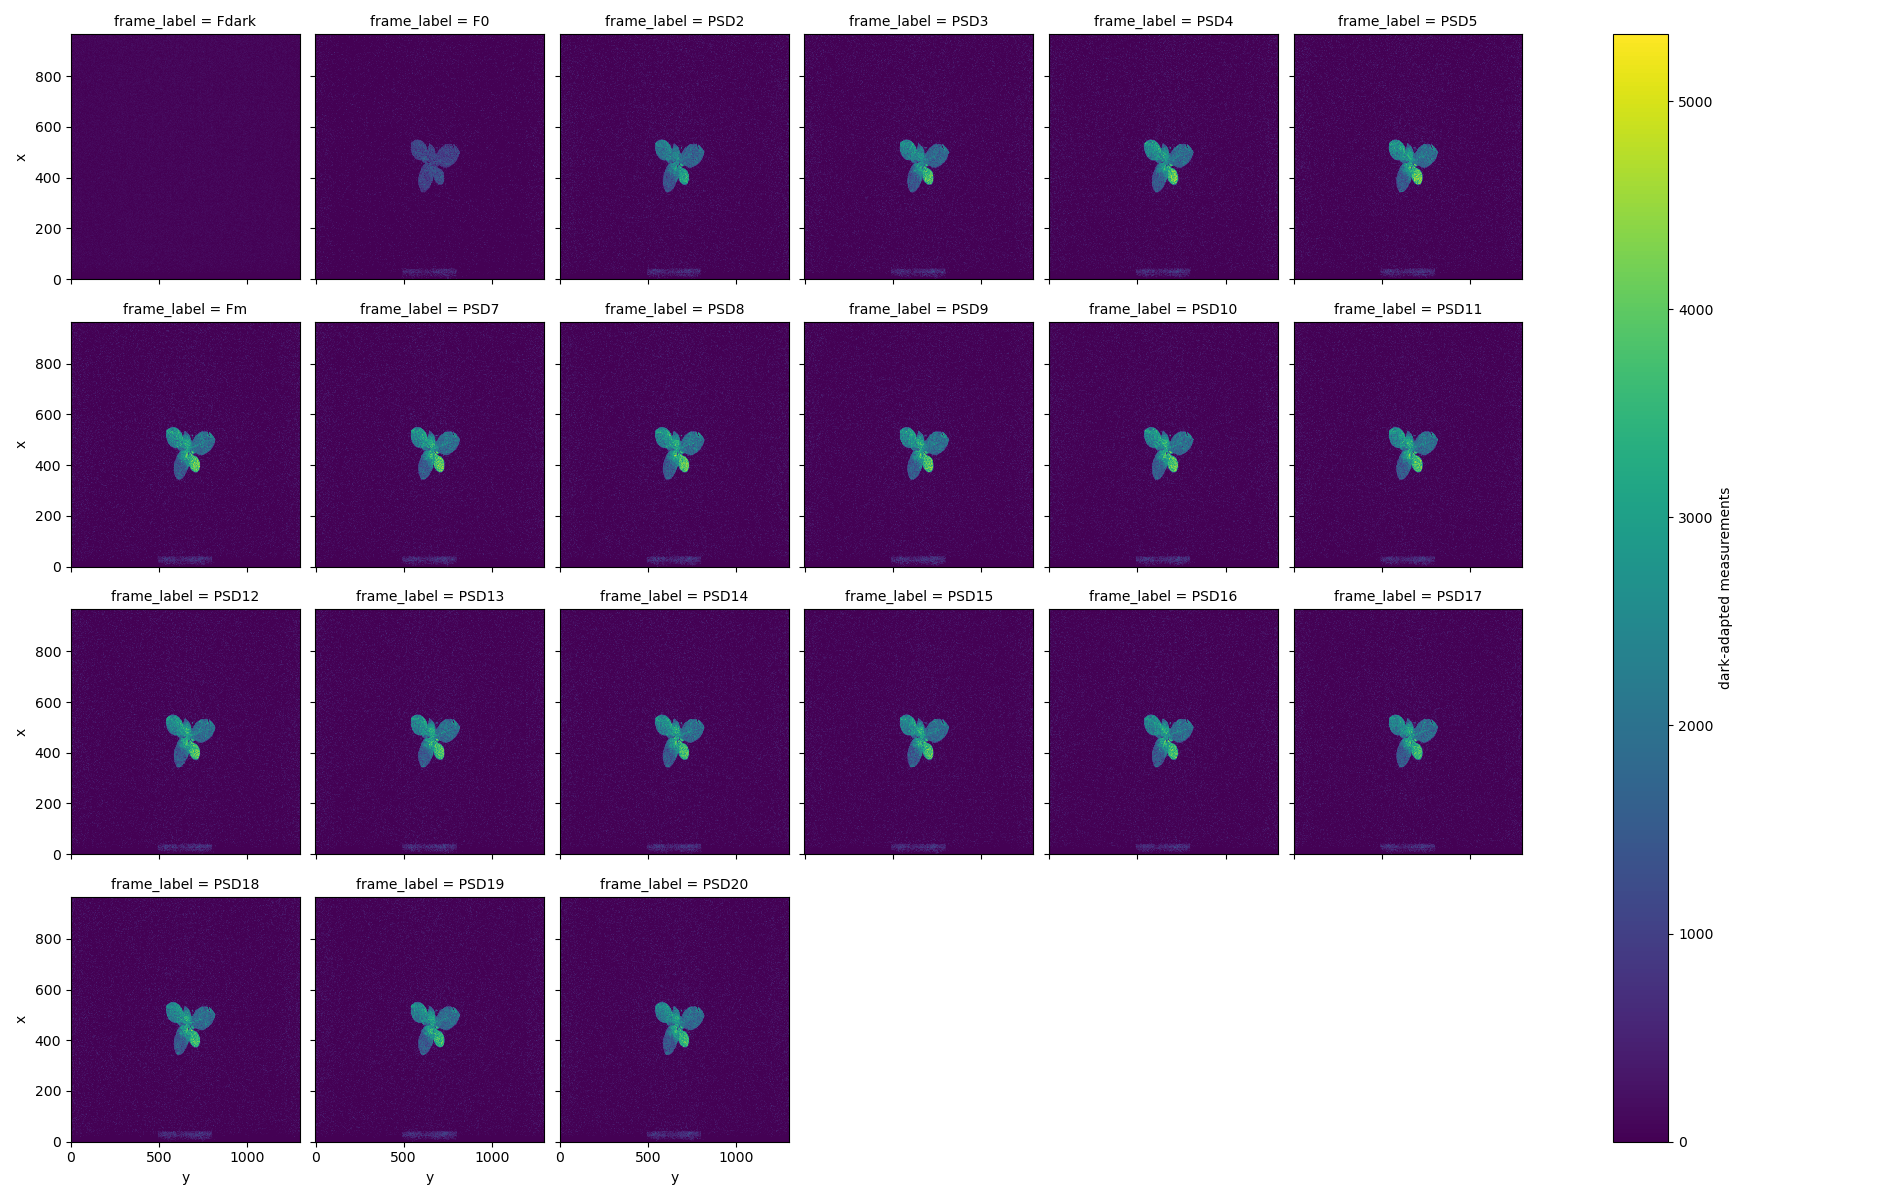

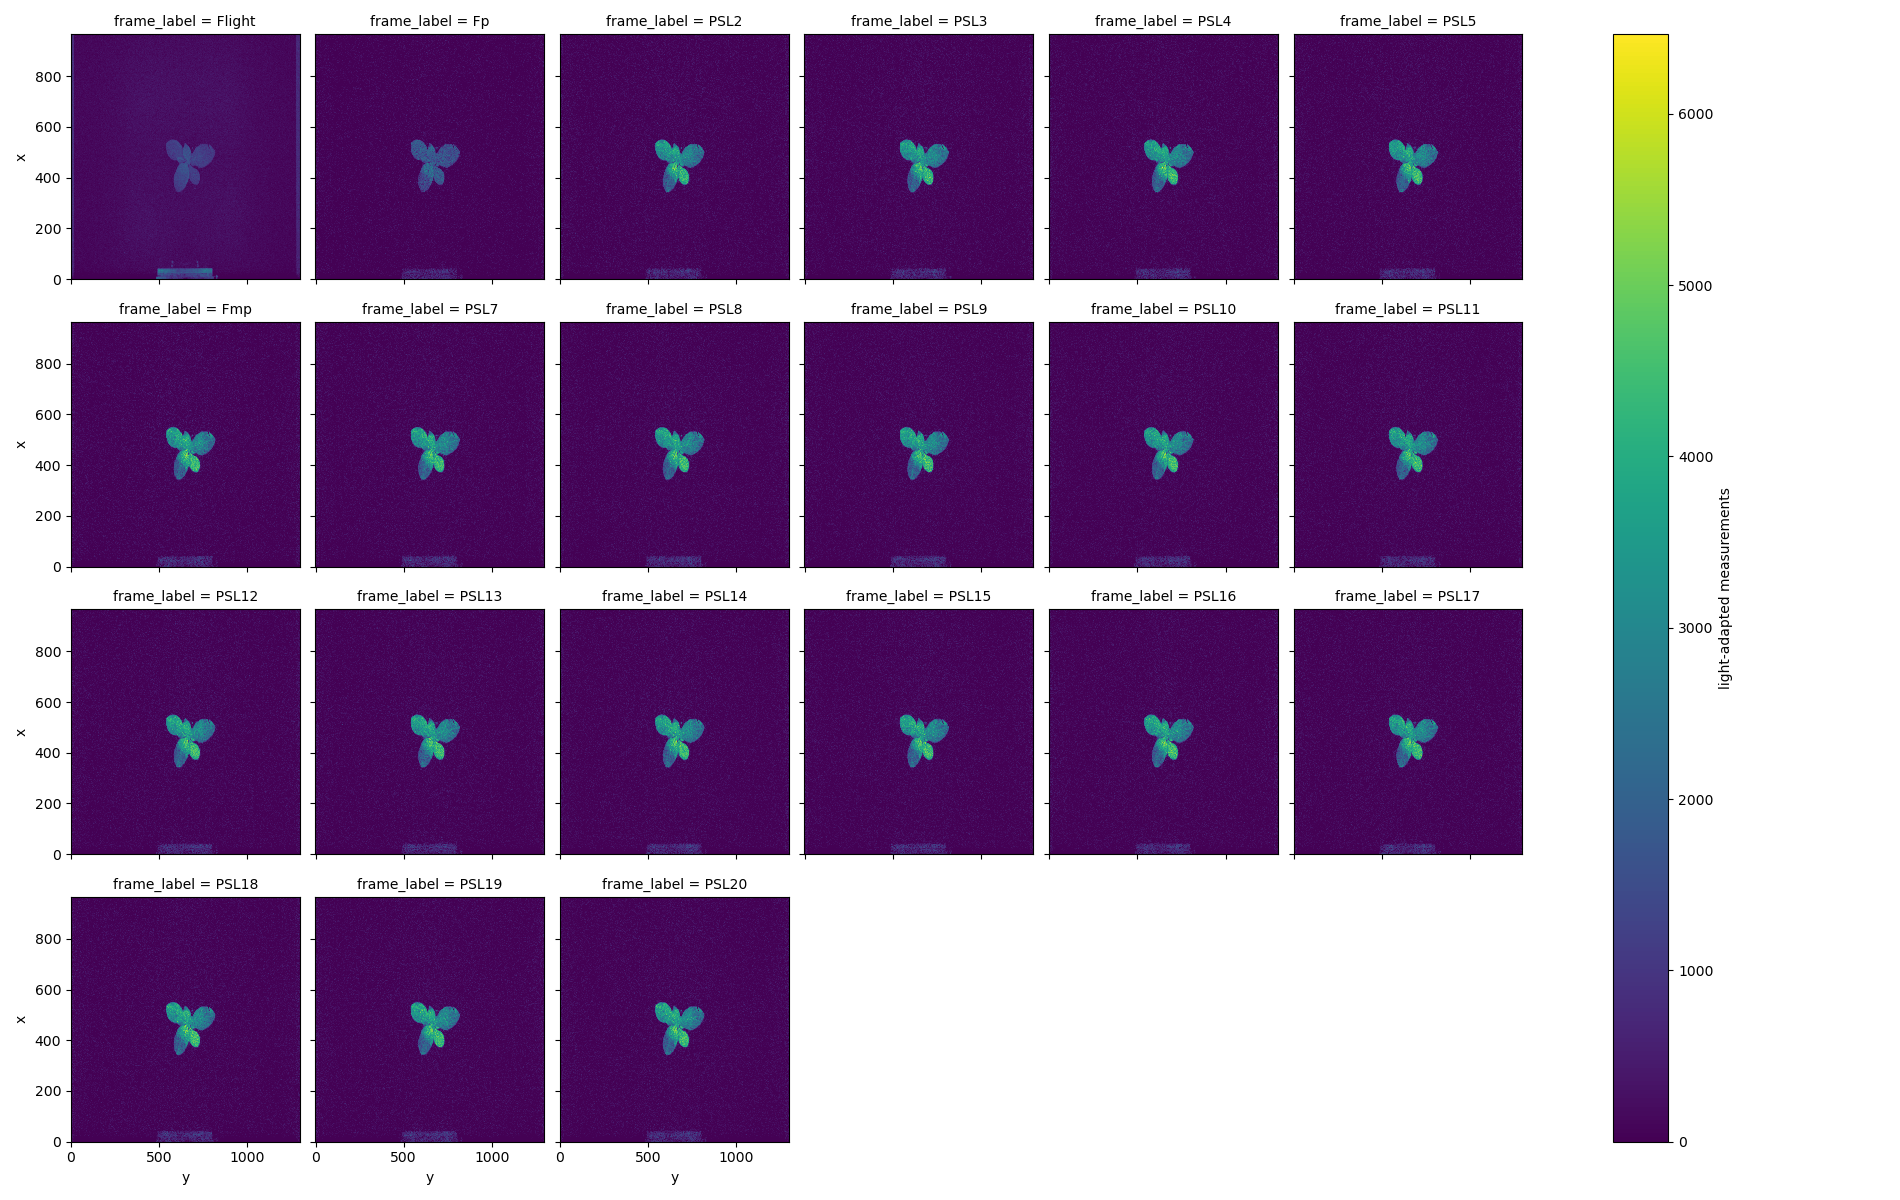

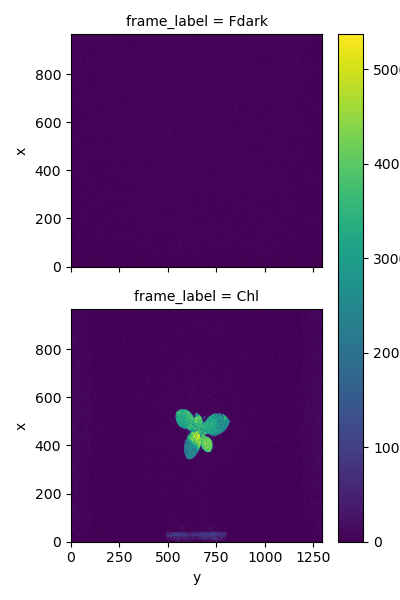

In [8]:
# Read fluorescence image data
# This will visualize all of the frames in all of the data you collected

# Inputs:
#   filename - Image file to be read in (should be an .INF file)
ps = pcv.photosynthesis.read_cropreporter(filename=infile)

## Create a mask

In the code below, we select the chlorophyll "CHL" frame as our grayscale image from which the mask will be created. It is possible to use any frame for creating a mask, but it is easier to use an image with decent contrast between the object of interest (the plant) and the background. 

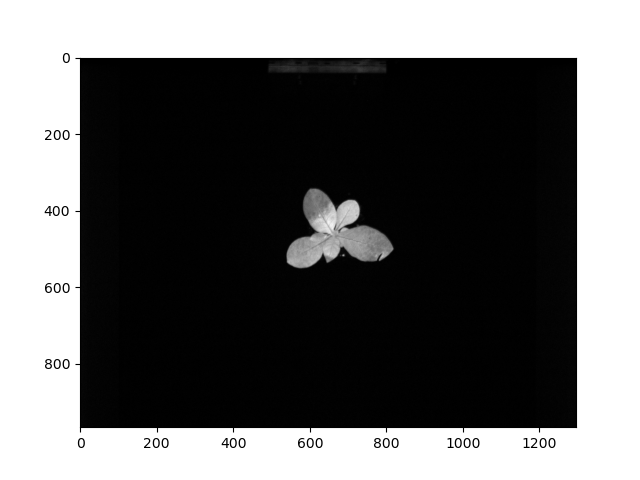

In [9]:
img = ps.chlorophyll.sel(frame_label = "Chl").data
pcv.plot_image(img)

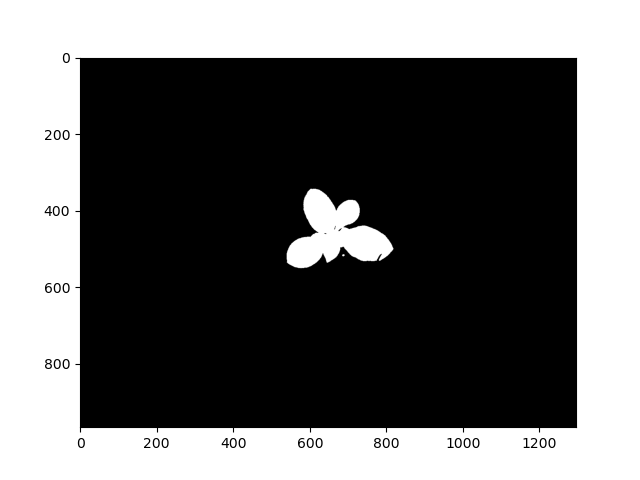

In [11]:
# Threshold the chlorophyll image in order to separate the plant from the background
# For additional thresholding methods (such as binary), see the thresholding tutorial and documentation

# Inputs:
#   gray_img        - Grayscale image data
#   object_type     - 'light' (default) or 'dark'. If the object is lighter than the
#                       background then standard threshold is done. If the object is
#                       darker than the background then inverse thresholding is done.

plant_mask = pcv.threshold.otsu(gray_img=img, object_type="light")



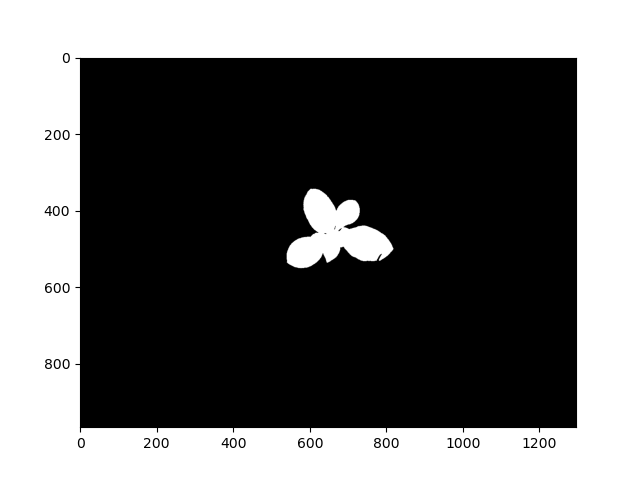

In [12]:
# Fill small objects to remove noise and get a complete plant

# Inputs:
#   bin_img         - Binary image data
#   size            - Minimum object area size in pixels (integer), smaller objects get filled in.

filled_mask = pcv.fill(bin_img=plant_mask, size=200)

Segmentation accuracy depends largely on the quality of the imaging data collection setup, but the importance of this accuracy also depends on the experimental questiton that a workflow aims to answer. In the case of photosynthesis/fluorescence datasets, it's recommended that segmentation of plants be more conservative. In other words, it's more detrimental for PSII results to have background signal captured within a plant mask than it is to exclude some true plant signal in analysis. Plant movement, reflections within imaging cabinets, and other factors can influence the signal around the edges of an object. To address this, we will preform a morphological erosion to remove the edges.  

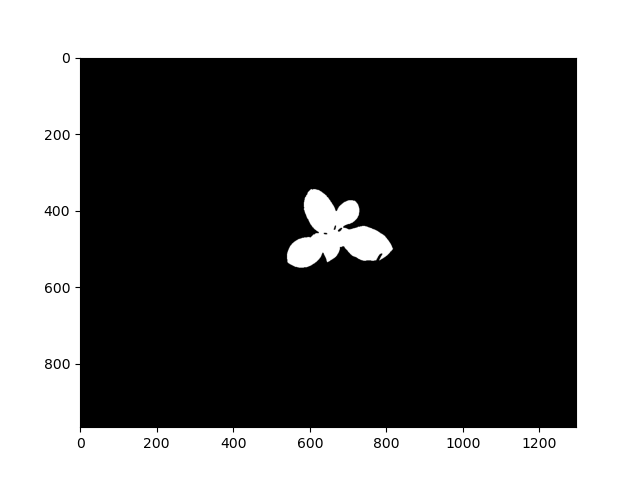

In [14]:
# Erode a small border of pixels from the mask 

# Inputs:
#   gray_img - Grayscale (usually binary) image data 
#   ksize - The size used to build a ksize x ksize 
#            matrix using np.ones. Must be greater than 1 to have an effect 
#   i - An integer for the number of iterations 
eroded_mask = pcv.erode(gray_img=filled_mask, ksize=3, i=1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


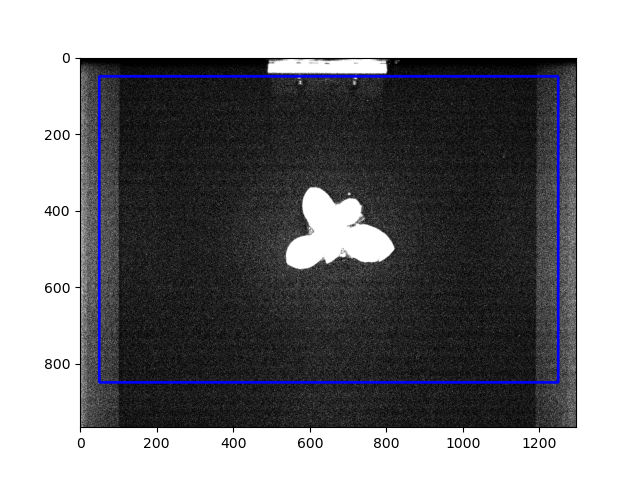

In [16]:
# Define the region of interest (ROI). This should include your plant, but not other things. This is a chance to remove problems in the edges of the image. 

# Inputs: 
#   img - RGB or grayscale image to plot the ROI on 
#   x - The x-coordinate of the upper left corner of the rectangle 
#   y - The y-coordinate of the upper left corner of the rectangle 
#   h - The height of the rectangle 
#   w - The width of the rectangle 

pcv.params.debug = "plot"

roi1 = pcv.roi.rectangle(img=img, x=50, y=50, h=800, w=1200)

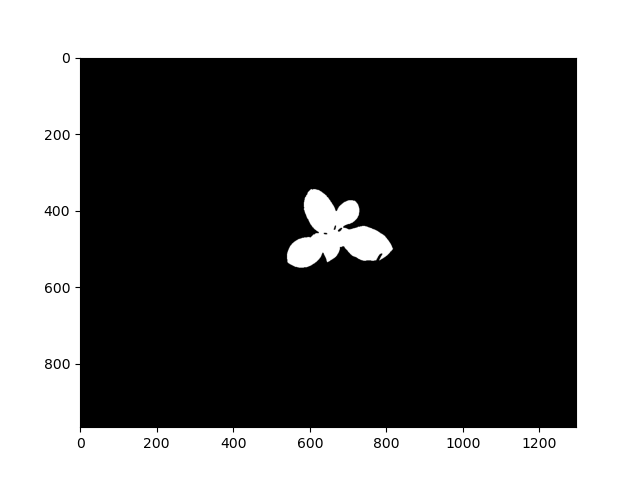

In [18]:
# Make a new filtered mask that only keeps the plant in your ROI and not objects outside of the ROI
# We have set to partial here so that if a leaf extends outside of your ROI it will still be selected. Switch to "cutto" if you have other plants that are getting selected on accident

# Inputs:
#    mask            = the clean mask you made above
#    roi            = the region of interest you specified above
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)

kept_mask  = pcv.roi.filter(mask=eroded_mask, roi=roi1, roi_type='partial')

# Analyze Photosynthetic Parameters

Visualize the chlorophyll fluorescence induction curves (optional)¶
In this experiment, the plant was dark-adapted. An image is taken of the plant in the dark (F-dark). The plant is then exposed to a saturating red light pulse briefly. An image of chlorophyll fluorescence is taken immediately after the pulse to measure minimal fluorescence (F0). Successive images are taken at a fixed time interval (20 total frames from F0 to F19 in this example). Here we will chart the induction curves using visualize.chlorophyll_fluorescence to see if the maximum fluorescence frames are set at a reasonable place or whether we want to adjust them in a later step.

In [19]:
# Dark-adapted fluorescence induction curve
# This curve is only for the object in your kept mask from above

# Inputs:
# ps_da            = photosynthesis xarray DataArray
# labeled_mask     = Labeled mask of objects (32-bit).
# n_labels         = Total number expected individual objects (default = 1).
# label            = optional label parameter, modifies the prefix of the group plotting label

# Returns:
# chart            = Plot of the chlorophyll fluorescence induction curve for each object

dark_fig = pcv.visualize.chlorophyll_fluorescence(ps_da=ps.darkadapted, labeled_mask=kept_mask)

alt.LayerChart(...)

After the Fv/Fm protocol, the plant is light-adapted. An image is taken of the plant in the light (F-light). The plant is then exposed to an actinic light, and an image of chlorophyll fluorescence is taken to measure steady-state fluorescence (F'). The plant is then exposed to a saturating red light pulse briefly. Successive images are taken at a fixed time interval (20 total frames from F0 to F19 in this example). Here we will use the visualize.chlorophyll_fluorescence function to chart the fluorescence induction curve.

In [21]:
# Light-adapted fluorescence induction curve

# Inputs:
# ps_da            = photosynthesis xarray DataArray
# labeled_mask     = Labeled mask of objects (32-bit).
# n_labels         = Total number expected individual objects (default = 1).
# label            = optional label parameter, modifies the prefix of the group plotting label

# Returns:
# chart            = Plot of the chlorophyll fluorescence induction curve for each object

light_fig = pcv.visualize.chlorophyll_fluorescence(ps_da=ps.lightadapted, labeled_mask=kept_mask)

alt.LayerChart(...)

# Estimate the efficiency of PSII

Using the dark-adapted and light-adapted datasets, calculate the metric Fv/Fm to estimate the maximum efficiency of PSII and the metric Fq'/Fm' to estimate the operating efficiency of PSII. In both cases the function analyze.yii is used. Setting auto_fm=True will use photosynthesis.reassign_frame_labels to automatically find the frame with the maximum fluorescence for each masked region.

In [ ]:
# Analyze Fv/Fm

# Inputs:
# ps_da               = Photosynthesis xarray DataArray (either darkadapted or lightadapted)
# labeled_mask        = Labeled mask of objects (32-bit).
# n_labels            = Total number expected individual objects (default = 1).
# auto_fm             = Automatically calculate the frame with maximum fluorescence per label, otherwise
#                       use a fixed frame for all labels (default = False).
# measurement_labels  = labels for each measurement, modifies the variable name of observations recorded
# label               = optional label parameter, modifies the variable name of observations recorded

# Returns:
# yii_global          = DataArray of efficiency estimate values
# yii_chart           = Histograms of efficiency estimate

fvfm, fvfm_hist = pcv.analyze.yii(ps_da=ps.darkadapted, labeled_mask=kept_mask, auto_fm=True,
                                    measurement_labels=["Fv/Fm"], label="plant")


In [ ]:
# Analyze Fq'/Fm'

# Inputs:
# ps_da               = Photosynthesis xarray DataArray (either darkadapted or lightadapted)
# labeled_mask        = Labeled mask of objects (32-bit).
# n_labels            = Total number expected individual objects (default = 1).
# auto_fm             = Automatically calculate the frame with maximum fluorescence per label, otherwise
#                       use a fixed frame for all labels (default = False).
# measurement_labels  = labels for each measurement, modifies the variable name of observations recorded
# label               = optional label parameter, modifies the variable name of observations recorded

# Returns:
# yii_global          = DataArray of efficiency estimate values
# yii_chart           = Histograms of efficiency estimate

fqfm, fqfm_hist = pcv.analyze.yii(ps_da=ps.lightadapted, labeled_mask=mask, auto_fm=True,
                                    measurement_labels=["Fq'/Fm'"], label="plant")

# Estimate non-photochemical quenching 

Nonphotochemical quanching (NPQ) can be estimated using the analyze.npq function.

In [ ]:
# Analyze NPQ

# Inputs:
# ps_da_light        = Photosynthesis xarray DataArray that contains frame_label `Fmp` (lightadapted)
# ps_da_dark         = Photosynthesis xarray DataArray that contains frame_label `Fm` (darkadapted)
# labeled_mask       = Labeled mask of objects (32-bit).
# n_labels           = Total number expected individual objects (default = 1).
# auto_fm            = Automatically calculate the frame with maximum fluorescence per label, otherwise
#                      use a fixed frame for all labels (default = False).
# min_bin            = minimum bin value ("auto" or user input minimum value - must be an integer)
# max_bin            = maximum bin value ("auto" or user input maximum value - must be an integer)
# measurement_labels = labels for each measurement in ps_da_light, modifies the variable name of observations recorded
# label              = optional label parameter, modifies the entity name of observations recorded

# Returns:
# npq_global         = DataArray of NPQ values
# npq_chart          = Histograms of NPQ estimates

npq, npq_hist = pcv.analyze.npq(ps_da_light=ps.lightadapted, ps_da_dark=ps.darkadapted, labeled_mask=kept_mask,
                                auto_fm=True, measurement_labels=["NPQ"], label="plant")

Optionally, the Fv/Fm, Fq'/Fm', and NPQ images can be visualized using the pseudocolor function to assess the distribution of values across the plant.

In [ ]:
# Pseudocolor the PSII metric images

# Inputs:
# gray_img    - grayscale image data
# obj         - (optional) ROI or plant contour object. If provided, the pseudocolored image gets cropped
#               down to the region of interest. default = None
# mask        - (optional) binary mask
# cmap        - (optional) colormap. default is the matplotlib default, viridis
# background  - (optional) background color/type, options are "image" (gray_img), "white", or "black"
#               (requires a mask). default = 'image'
# min_value   - (optional) minimum value for range of interest. default = 0
# max_value   - (optional) maximum value for range of interest. default = 255
# axes        - (optional) if False then x- and y-axis won't be displayed, nor will the title. default = True
# colorbar    - (optional) if False then colorbar won't be displayed. default = True
# obj_padding - (optional) if "auto" (default) and an obj is supplied, then the image is cropped to an extent 20%
#               larger in each dimension than the object. An single integer is also accepted to define the padding
#               in pixels
# title       - (optional) custom title for the plot gets drawn if title is not None. default = None
# bad_mask    - (optional) binary mask of pixels with "bad" values, e.g. nan or inf or any other values considered
#               to be not informative and to be excluded from analysis. default = None
# bad_color   - (optional) desired color to show "bad" pixels. default = "red"
fvfm_cmap = pcv.visualize.pseudocolor(gray_img=fvfm, mask=kept_mask, cmap="viridis", 
                                        min_value=0, max_value=1, title="Fv/Fm")
fqfm_cmap = pcv.visualize.pseudocolor(gray_img=fqfm, mask=kept_mask, cmap="viridis", 
                                        min_value=0, max_value=1, title="Fq'/Fm'")
npq_cmap = pcv.visualize.pseudocolor(gray_img=npq, mask=kept_mask, cmap="viridis", 
                                        min_value=0, max_value=1, title="NPQ")


# Analyze spectral indices

# Anthocyanin Reflectance Index
Calculate ARI using the ari function, plot a colormap, and analyze the plant values.

In [ ]:
# Inputs:
# hsi         = hyperspectral image (PlantCV Spectral_data instance)
# distance    = how lenient to be if the required wavelengths are not available
# 
# Returns:
# index_array = Index data as a Spectral_data instance
ari = pcv.spectral_index.ari(hsi=ps.spectral)

ari_ps = pcv.visualize.pseudocolor(gray_img=ari.array_data, min_value=0, max_value=10, 
                                    cmap="Purples", mask=kept_mask, background="black", 
                                    title="Anthocyanin Reflectance Index")
# Inputs:
# index_img    = Index image data (PlantCV Spectral_data object)
# labeled_mask = Labeled mask of objects (32-bit).
# n_labels     = Total number expected individual objects (default = 1).
# bins         = Number of histogram bins (default = 100)
# min_bin      = Minimum bin value (default = 0). "auto" will use the minimum value of the index image.
# max_bin      = Maximum bin value (default = 1). "auto" will use the maximum value of the index image.
# label        = optional label parameter, modifies the variable name of observations recorded (default = "default").

# Returns:
# index_hist = Spectral index histogram plot
ari_hist = pcv.analyze.spectral_index(index_img=ari, labeled_mask=kept_mask, min_bin=0, max_bin=10, label="plant")


# Chlorophyll Index Red Edge

Calculate CI using the ci_rededge function, plot a colormap, and analyze the plant values.

In [ ]:
# Inputs:
# hsi         = hyperspectral image (PlantCV Spectral_data instance)
# distance    = how lenient to be if the required wavelengths are not available
# 
# Returns:
# index_array = Index data as a Spectral_data instance
ci = pcv.spectral_index.ci_rededge(hsi=ps.spectral)

ci_ps = pcv.visualize.pseudocolor(gray_img=ci.array_data, min_value=0, max_value=5, 
                                    cmap="Greens", mask=kept_mask, background="black", 
                                    title="Chlorophyll Index Red Edge")
# Inputs:
# index_img    = Index image data (PlantCV Spectral_data object)
# labeled_mask = Labeled mask of objects (32-bit).
# n_labels     = Total number expected individual objects (default = 1).
# bins         = Number of histogram bins (default = 100)
# min_bin      = Minimum bin value (default = 0). "auto" will use the minimum value of the index image.
# max_bin      = Maximum bin value (default = 1). "auto" will use the maximum value of the index image.
# label        = optional label parameter, modifies the variable name of observations recorded (default = "default").

# Returns:
# index_hist = Spectral index histogram plot
ci_hist = pcv.analyze.spectral_index(index_img=ci, labeled_mask=kept_mask, min_bin=0, max_bin=5, label="plant")


# Normalized Difference Vegetation Index
Calculate NDVI using the ndvi function, plot a colormap, and analyze the plant values.

In [ ]:
# Inputs:
# hsi         = hyperspectral image (PlantCV Spectral_data instance)
# distance    = how lenient to be if the required wavelengths are not available
# 
# Returns:
# index_array = Index data as a Spectral_data instance
ndvi = pcv.spectral_index.ndvi(hsi=ps.spectral)

ndvi_ps = pcv.visualize.pseudocolor(gray_img=ndvi.array_data, min_value=0, max_value=1, 
                                    cmap="jet", mask=mask, background="black", 
                                    title="Normalized Difference Vegetation Index")
# Inputs:
# index_img    = Index image data (PlantCV Spectral_data object)
# labeled_mask = Labeled mask of objects (32-bit).
# n_labels     = Total number expected individual objects (default = 1).
# bins         = Number of histogram bins (default = 100)
# min_bin      = Minimum bin value (default = 0). "auto" will use the minimum value of the index image.
# max_bin      = Maximum bin value (default = 1). "auto" will use the maximum value of the index image.
# label        = optional label parameter, modifies the variable name of observations recorded (default = "default").

# Returns:
# index_hist = Spectral index histogram plot
ndvi_hist = pcv.analyze.spectral_index(index_img=ndvi, labeled_mask=mask, min_bin=0, max_bin=1, label="plant")


# Save results and finish the workflow¶

In [ ]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 

#This saves results for one image, and each image is saved individually if you run another image (it will overwrite the last one)
pcv.outputs.save_results(filename=args.result)

if args.writeimg:
    pcv.print_image(img=dark_fig, filename=os.path.join(args.outdir, ps.filename[:-4] + "_fvfm_induction.png"))
    pcv.print_image(img=light_fig, filename=os.path.join(args.outdir, ps.filename[:-4] + "_fqfm_induction.png"))
    pcv.print_image(img=fvfm_hist, filename=os.path.join(args.outdir, ps.filename[:-4] + "_fvfm_histogram.png"))
    pcv.print_image(img=fqfm_hist, filename=os.path.join(args.outdir, ps.filename[:-4] + "_fqfm_histogram.png"))
    pcv.print_image(img=npq_hist, filename=os.path.join(args.outdir, ps.filename[:-4] + "_npq_histogram.png"))
    pcv.print_image(img=fvfm_cmap, filename=os.path.join(args.outdir, ps.filename[:-4] + "_fvfm_cmap.png"))
    pcv.print_image(img=fqfm_cmap, filename=os.path.join(args.outdir, ps.filename[:-4] + "_fqfm_cmap.png"))
    pcv.print_image(img=npq_cmap, filename=os.path.join(args.outdir, ps.filename[:-4] + "_npq_cmap.png"))
    pcv.print_image(img=ari_ps, filename=os.path.join(args.outdir, ps.filename[:-4] + "_ari_cmap.png"))
    pcv.print_image(img=ari_hist, filename=os.path.join(args.outdir, ps.filename[:-4] + "_ari_hist.png"))
    pcv.print_image(img=ci_ps, filename=os.path.join(args.outdir, ps.filename[:-4] + "_ci_cmap.png"))
    pcv.print_image(img=ci_hist, filename=os.path.join(args.outdir, ps.filename[:-4] + "_ci_hist.png"))
    pcv.print_image(img=ndvi_ps, filename=os.path.join(args.outdir, ps.filename[:-4] + "_ndvi_cmap.png"))
    pcv.print_image(img=ndvi_hist, filename=os.path.join(args.outdir, ps.filename[:-4] + "_ndvi_hist.png"))


## Congrats, you now know all the settings you like for this day of imaging! It's time to make this into a workflow so that it will analyze all your images at once and you can go have a cup of coffee. To do so, go back to the folder and open up the config_template.json file, and the config_workflow.py files, and you will edit them according to the values you changed in this file. 